# Statement

A companhia de seguros Proteja Seu Amanhã quer resolver algumas tarefas com a ajuda de aprendizado de máquina e você precisa avaliar a possibilidade de fazê-lo.

- Tarefa 1: Encontrar clientes semelhantes a um determinado cliente. Isso vai ajudar os agentes da empresa com tarefas de marketing.
- Tarefa 2: Predizer se um novo cliente provavelmente receberá um pagamento de seguro. Um modelo de predição pode ser melhor do que um modelo dummy?
- Tarefa 3: Predizer o número de pagamentos de seguro que um novo cliente provavelmente receberá usando um modelo de regressão linear.
- Tarefa 4: Proteger os dados pessoais dos clientes sem estragar o modelo da tarefa anterior. É necessário desenvolver um algoritmo de transformação de dados que tornaria difícil recuperar informações pessoais se os dados caíssem nas mãos erradas. Isso é chamado de mascaramento de dados ou ofuscação de dados. Mas os dados devem ser protegidos de forma que a qualidade dos modelos de aprendizado de máquina não piore. Você não precisa escolher o melhor modelo, só prove que o algoritmo funciona corretamente.

# Pré-processamento de dados & Exploração

## Inicialização

In [1]:
# importando bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import math
from sklearn.model_selection import train_test_split

## Carregar Dados

Carregue os dados e faça uma verificação básica de que estão livres de problemas óbvios.

In [2]:
df = pd.read_csv('insurance_us.csv')

Renomeamos as colunas para tornar o código mais consistente com seu estilo.

In [3]:
df = df.rename(
    columns={
        'Gender': 'gender',
        'Age': 'age',
        'Salary': 'income',
        'Family members': 'family_members',
        'Insurance benefits': 'insurance_benefits'
    })

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
647,1,33.0,39500.0,1,0
643,1,22.0,35800.0,2,0
2693,0,18.0,42600.0,1,0
3264,1,35.0,43100.0,2,0
2625,1,28.0,50300.0,2,0
1447,0,35.0,25900.0,3,0
2602,1,27.0,35000.0,1,0
2906,1,24.0,48300.0,1,0
4006,1,27.0,50600.0,2,0
1753,1,29.0,30900.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# podemos querer corrigir o tipo de idade (de float para int), embora isso não seja crítico
# escreva sua conversão aqui se você escolher:
df['age'] = df['age'].astype(int)

In [7]:
# verifique se a conversão foi bem-sucedida
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int32  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 175.9 KB


In [8]:
# agora dê uma olhada nas estatísticas descritivas dos dados.
# Parece que está tudo bem?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [9]:
df.duplicated().sum()

153

In [10]:
df=df.drop_duplicates()
df.duplicated().sum()

0

## AED

Vamos verificar rapidamente se existem determinados grupos de clientes observando o gráfico de pares.

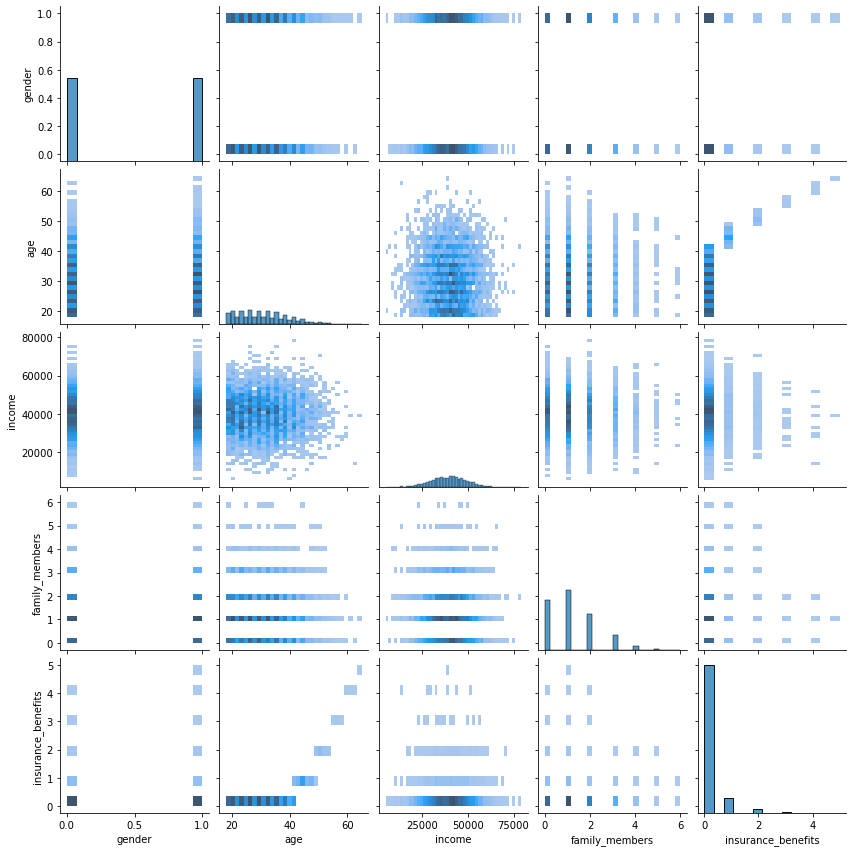

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, é um pouco difícil identificar grupos óbvios (clusters), pois é difícil combinar várias variáveis simultaneamente (para analisar distribuições multivariadas). É aí que Álgebra Linear e Aprendizado de Máquina podem ser bastante úteis.

# Tarefa 1. Clientes Similares

Na linguagem de AM, é necessário desenvolver um procedimento que retorne k vizinhos mais próximos (objetos) para um determinado objeto com base na distância entre os objetos.
Você pode querer rever as seguintes lições (capítulo -> lição)- Distância Entre Vetores -> Distância Euclidiana
- Distância Entre Vetores -> Distância de Manhattan

Para resolver a tarefa, podemos tentar diferentes métricas de distância.

Escreva uma função que retorne k vizinhos mais próximos para um n-ésimo objeto com base em uma métrica de distância especificada. O número de pagamentos de seguro recebidos não deve ser levado em consideração para esta tarefa. 

Você pode usar uma implementação pronta do algoritmo kNN do scikit-learn (verifique [o link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) ou usar a sua própria.
Teste-o para quatro combinações de dois casos
- Escalabilidade
  - os dados não são escalados
  - os dados escalados com o escalonador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) 
- Métricas de distância
  - Euclidiana
  - Manhattan

Responda às perguntas:
- Os dados não escalados afetam o algoritmo kNN? Se sim, como isso acontece?
-Quão semelhantes são os resultados usando a métrica de distância de Manhattan (independentemente da escalabilidade)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    """
    Retorna os vizinhos mais próximos de k

    :param df: DataFrame pandas usado para encontrar objetos semelhantes dentro de    :param n: número do objeto pelo qual os vizinhos mais próximos são procurados
    :param k: o número dos vizinhos mais próximos a serem retornados
    :param metric: nome da métrica de distância    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]],
                                                   k,
                                                   return_distance=True)

    df_res = pd.concat([
        df.iloc[nbrs_indices[0]],
        pd.DataFrame(
            nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
    ],
                       axis=1)

    return df_res

Escalando os dados

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(
    df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(
    df[feature_names].to_numpy())

In [15]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1154,0.0,0.553846,0.387342,0.166667,0
4787,0.0,0.292308,0.417722,0.000000,0
4507,0.0,0.338462,0.189873,0.000000,0
1436,1.0,0.276923,0.415190,0.333333,0
2942,0.0,0.707692,0.460759,0.000000,1


Agora, vamos obter registros semelhantes para um determinado registro para cada combinação

In [16]:
def knn_register(df, k, n, scaling='scaled', metrics=[]):
    for metric in metrics:
        print(f'{scaling} {metric}')
        print(get_knn(df, n, k, metric))
        print()

In [17]:
metrics = ['euclidean', 'manhattan']
knn_register(df[feature_names], k=5, n=50, scaling='Unscaled', metrics=metrics)

Unscaled euclidean
      gender   age   income  family_members  distance
50       1.0  28.0  39600.0             0.0  0.000000
3766     1.0  29.0  39600.0             0.0       NaN
1547     0.0  21.0  39600.0             0.0       NaN
2930     0.0  21.0  39600.0             3.0       NaN
270      1.0  36.0  39600.0             0.0  8.000000
3663     NaN   NaN      NaN             NaN  1.000000
1531     NaN   NaN      NaN             NaN  7.071068
2865     NaN   NaN      NaN             NaN  7.681146

Unscaled manhattan
      gender   age   income  family_members  distance
50       1.0  28.0  39600.0             0.0       0.0
3766     1.0  29.0  39600.0             0.0       NaN
270      1.0  36.0  39600.0             0.0       8.0
1547     0.0  21.0  39600.0             0.0       NaN
3313     0.0  19.0  39600.0             0.0       NaN
3663     NaN   NaN      NaN             NaN       1.0
1531     NaN   NaN      NaN             NaN       8.0
3228     NaN   NaN      NaN             NaN

C:\Users\Filipe\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\Filipe\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [18]:
df_scaled = df_scaled.reset_index(drop=True)
metrics = ['euclidean', 'manhattan']
knn_register(df_scaled[feature_names], k=5, n=50, metrics=metrics)

scaled euclidean
      gender       age    income  family_members  distance
50       1.0  0.430769  0.501266             0.0  0.000000
948      1.0  0.430769  0.502532             0.0  0.001266
939      1.0  0.430769  0.500000             0.0  0.001266
4749     1.0  0.430769  0.503797             0.0  0.002532
116      1.0  0.430769  0.487342             0.0  0.013924

scaled manhattan
      gender       age    income  family_members  distance
50       1.0  0.430769  0.501266             0.0  0.000000
948      1.0  0.430769  0.502532             0.0  0.001266
939      1.0  0.430769  0.500000             0.0  0.001266
4749     1.0  0.430769  0.503797             0.0  0.002532
116      1.0  0.430769  0.487342             0.0  0.013924



C:\Users\Filipe\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\Filipe\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


Respostas para as perguntas

**Os dados não escalados afetam o algoritmo kNN? Se sim, como isso acontece?** 

Sim, isso acontece pelo dados estarem em uma escala diferente.

**Quão semelhantes são os resultados usando a métrica de distância de Manhattan (independentemente da escalabilidade)?** 

Existem algumas diferenças entre as duas métricas.

# Tarefa 2. É provável que o cliente receba um pagamento do seguro?

Em termos de aprendizado de máquina, podemos olhar para isso como uma tarefa de classificação binária.

Com os pagamentos de seguro sendo mais do que zero como objetivo, avalie se a abordagem da classificação kNN pode ser melhor do que um modelo dummy.

Instruções:
- Construa um classificador baseado em kNN e meça sua qualidade com a métrica F1 para k=1..10 tanto para os dados originais quanto para os escalados. Seria interessante ver como k pode influenciar a métrica de avaliação e se a escalabilidade dos dados faz alguma diferença. Você pode usar uma implementação pronta do algoritmo de classificação kNN do scikit-learn (verifique [o link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) ou usar a sua própria.
- Construa o modelo dummy, que é aleatório para este caso. Deve retornar com alguma probabilidade o valor "1". LVamos testar o modelo com quatro valores de probabilidade: 0, a probabilidade de fazer qualquer pagamento de seguro, 0,5, 1.

A probabilidade de fazer qualquer pagamento de seguro pode ser definida como

$$
P\{\text{pagamento de seguro recebido}= número de clientes que receberam qualquer pagamento de seguro}}{\text{número total de clientes}}.
$$

Divida os dados inteiros na proporção 70:30 para as partes de treinamento/teste.

In [19]:
# calcule a meta
df['insurance_benefits_received'] = df['insurance_benefits'] > 0.5

In [20]:
# verifique o desequilíbrio de classe com value_counts()
df['insurance_benefits_received'].value_counts()

False    4284
True      563
Name: insurance_benefits_received, dtype: int64

In [21]:
def eval_classifier(y_true, y_pred):

    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')

    # se você tiver um problema com a linha a seguir, reinicie o kernel e execute o caderno novamente
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de Confusão')
    print(cm)

In [22]:
# gerando saída de um modelo aleatório
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'A probabilidade: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))

    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)

    print()

A probabilidade: 0.00
F1: 0.00
Matriz de Confusão
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

A probabilidade: 0.12
F1: 0.13
Matriz de Confusão
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

A probabilidade: 0.50
F1: 0.19
Matriz de Confusão
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

A probabilidade: 1.00
F1: 0.21
Matriz de Confusão
[[0.         0.88384568]
 [0.         0.11615432]]



# Tarefa 3. Regressão (com Regressão Linear)

Com os pagamentos de seguro como objetivo, avalie qual seria o REQM para um modelo de Regressão Linear.

Construa sua própria implementação de Regressão Linear. Para isso, lembre-se de como a solução da tarefa de regressão linear é formulada em termos de Álgebra linear. Verifique o REQM para os dados originais e os escalados. Você pode ver alguma diferença no REQM entre esses dois casos?

Vamos denotar
- $X$ — matriz de características, cada linha é um caso, cada coluna é uma característica, a primeira coluna consiste em unidades
- $y$ — objetivo (um vetor)
- $\hat{y}$ — objetivo estimado (um vetor)- $w$ — vetor de peso

A tarefa de regressão linear na linguagem de matrizes pode ser formulada como
$$
y = Xw
$$

O objetivo do treinamento, então, é encontrar os $w$ que minimizaria a distância L2 (EQM) entre $Xw$ e $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que há uma solução analítica para a questão acima:

$$
w = (X^T X)^{-1} X^T y
$$

A fórmula acima pode ser usada para encontrar os pesos $w$ e o último pode ser usado para calcular valores preditos

$$
\hat{y} = X_{val}w
$$

Divida todos os dados na proporção 70:30 para as partes de treinamento/validação. Use a métrica REQM para a avaliação do modelo.

In [24]:
class MyLinearRegression:
    def __init__(self):

        self.weights = None

    def fit(self, X, y):

        # somando as unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):

        # somando as unidades
        X2 = np.append(np.ones([X.shape[0], 1]), X, axis=1)
        y_pred = np.dot(X2, self.weights)

        return y_pred

In [25]:
def eval_regressor(y_true, y_pred):

    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'REQM: {rmse:.2f}')

    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')

In [26]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
REQM: 0.36
R2: 0.66


# Tarefa 4. Ofuscando dados

É melhor ofuscar os dados multiplicando as características numéricas (lembre-se, elas podem ser vistos como a matriz $X$) por uma matriz invertível $P$. 

$$
X' = X \times P
$$

Tente fazer isso e verifique como os valores das características ficarão após a transformação. Aliás, a invertibilidade é importante aqui, portanto, certifique-se de que $P$ seja realmente invertível.

Você pode querer revisar a lição 'Matrizes e Operações com Matrizes -> Multiplicação de Matrizes' para relembrar a regra de multiplicação de matrizes e sua implementação com NumPy.

In [27]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [28]:
X = df_pn.to_numpy()

Gerando uma matriz $P$ aleatória.

In [29]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Verificando se a matriz $P$ é invertível

In [30]:
np.dot(P, np.linalg.inv(P))

array([[ 1.00000000e+00, -5.55111512e-17, -2.22044605e-16,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -1.11022302e-16,  1.00000000e+00,
         5.55111512e-17],
       [ 1.11022302e-16, -3.05311332e-16, -2.22044605e-16,
         1.00000000e+00]])

Você consegue adivinhar a idade ou a renda dos clientes após a transformação?

In [31]:
np.dot(X, P)

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Você pode recuperar os dados originais de $X′$ se souber $P$? Tente verificar isso com cálculos movendo $P$ do lado direito da fórmula acima para o esquerdo. As regras da multiplicação de matrizes são realmente úteis aqui

In [32]:
pd.DataFrame(np.dot(X, np.dot(P, np.linalg.inv(P))),
             columns=feature_names).head()

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,1.110223e-16,46.0,38000.0,1.000000e+00
2,0.000000e+00,29.0,21000.0,1.165734e-12
3,2.220446e-16,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,1.448841e-12


Imprima todos os três casos para alguns clientes- Os dados originais
- O transformado
- O invertido (recuperado)

In [33]:
print(pd.DataFrame(X, columns=feature_names).head())
print()
print(pd.DataFrame(np.dot(X, P), columns=feature_names).head())
print()
print(
    pd.DataFrame(np.dot(X, np.dot(P, np.linalg.inv(P))),
                 columns=feature_names).head())

   gender   age   income  family_members
0     1.0  41.0  49600.0             1.0
1     0.0  46.0  38000.0             1.0
2     0.0  29.0  21000.0             0.0
3     0.0  21.0  41700.0             2.0
4     1.0  28.0  26100.0             0.0

        gender           age        income  family_members
0  6359.715273  22380.404676  18424.090742    46000.696690
1  4873.294065  17160.367030  14125.780761    35253.455773
2  2693.117429   9486.397744   7808.831560    19484.860631
3  5345.603937  18803.227203  15479.148373    38663.061863
4  3347.176735  11782.829283   9699.998942    24211.273378

         gender   age   income  family_members
0  1.000000e+00  41.0  49600.0    1.000000e+00
1  1.110223e-16  46.0  38000.0    1.000000e+00
2  0.000000e+00  29.0  21000.0    1.165734e-12
3  2.220446e-16  21.0  41700.0    2.000000e+00
4  1.000000e+00  28.0  26100.0    1.448841e-12


Você provavelmente pode ver que alguns valores não são exatamente iguais aos dos dados originais. Qual pode ser a razão disso?

Isso acontence pelos valores serem flutuantes.

## Provas de que a ofuscação de dados pode funcionar com a Regressão Linear

A tarefa de regressão foi resolvida com regressão linear neste projeto. Sua próxima tarefa é provar analiticamente que o método de ofuscação fornecido não afetará a regressão linear em termos de valores preditos, ou seja, seus valores permanecerão os mesmos. Você acredita nisso? Bem, você não precisa acreditar, você deve provar isso!

Assim, os dados são ofuscados e há $X \ P$ em vez de apenas X agora. Consequentemente, existem outros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Como  $w$ e $w_P$ seriam ligados se você simplificasse a fórmula para $w_P$ acima? 

Quais seriam os valores previstos com $w_P$? 

O que isso significa para a qualidade da regressão linear se você medir com REQM?

Verifique o Apêndice B Propriedades das Matrizes no final do caderno. Existem fórmulas úteis lá!

Nenhum código é necessário nesta seção, apenas explicação analítica!

**Resposta**

Cálculo dos pesos 𝑤 na regressão linear tradicional usando a fórmula:
$$
w = (X^TX)^1 X^T y
$$

Introdução da matriz de ofuscação 𝑃 na equação para calcular os pesos na regressão linear ofuscada:
$$
wp = [(XP)^T(XP)]^{-1}(XP)^Ty
$$

Simplificação da expressão utilizando a propriedade da transposição:
$$
wp = [(XP)^T(XP)]^{-1}P^TX^Ty
$$

Reorganização dos termos para obter a expressão na forma desejada:
$$
wp = [P^TX^TXP]^{-1}P^TX^Ty
$$

Aplicação da inversão de matrizes para simplificar a expressão:
$$
wp = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty
$$

Demonstração de que o inverso de 𝑃𝑇 multiplicado por 𝑃𝑇 resulta na matriz identidade 𝐼:
$$
(P^T)^{-1}P^T=P^T(P^T)^{-1}=I
$$

Introdução da matriz identidade no numerador:
$$
wp = P^{-1}(X^TX)^{-1}IX^Ty
$$

Recuperação da fórmula original da regressão linear:
$$
w = (X^TX)^{-1}X^Ty
$$

Simplificação final, mostrando que os pesos da regressão linear ofuscada podem ser obtidos multiplicando-se a matriz inversa de 𝑃 pelos pesos da regressão linear original 𝑤:
$$
wp = P^{-1}w
$$

**Prova analítica**

O método de ofuscação não afeta a regressão linear em termos dos valores preditos.

## Teste de regressão linear com ofuscação de dados

Agora, vamos provar que a Regressão Linear pode funcionar computacionalmente com a transformação de ofuscação escolhida.
Crie um procedimento ou uma classe que execute a Regressão Linear opcionalmente com a ofuscação. Você pode usar uma implementação pronta de Regressão Linear do scikit-learn ou sua própria.

Execute a Regressão Linear para os dados originais e os ofuscados, compare os valores previstos e os valores da métrica $R^2$ do REQM. Há alguma diferença?

**Procedimento**

- Crie uma matriz quadrada $P$ de números aleatórios.
- Verifique se é invertível. Caso contrário, repita o primeiro ponto até obtermos uma matriz invertível.
- <! seu comentário aqui!>
- Use $XP$ como a nova matriz de características

In [34]:
# usando dados originais
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(np.dot(X, P), y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736668 -0.02714034 -0.04374255  0.10104869 -0.01541922]
REQM: 0.36
R2: 0.66


# Conclusões

Os resultados nos mostram que consiguimos obter os mesmos resultados mesmo após ter feito a ofuscação dos dados. Com o REQM em 0.36 e o R2 em 0.66

# Checklist

Digite 'x' para verificar. Em seguida, pressione Shift + Enter.

- [x]  O Jupyter Notebook está aberto.
- [x]  O código está livre de erros
- [x]  As células são organizadas em ordem de lógica e execução
- [x]  A tarefa 1 foi executada
    - [x]  Existe o procedimento que pode retornar k clientes semelhantes a um determinado cliente
    - [x]  O procedimento é testado para todas as quatro combinações propostas
    - [x]  As perguntas sobre a escala/distâncias são respondidas
- [x]  A tarefa 2 foi executada
    - [x]  O modelo de classificação aleatória é construído e testado para todos os níveis de probabilidade
    - [x]  O modelo de classificação kNN é construído e testado tanto para os dados originais quanto para os escalados, a métrica F1 é calculada.- [ ]  A tarefa 3 foi executada
    - [x]  A solução de regressão linear é implementada com operações matriciais.
    - [x]  O REQM é calculado para a solução implementada.
- [x]  A tarefa 4 foi executada
    - [x]  Os dados são ofuscados com uma matriz P aleatória e invertível
    - [x]  Os dados ofuscados são recuperados, alguns exemplos são impressos    - [x]  A prova analítica de que a transformação não afeta o REQM é fornecida
    - [x]  A prova computacional de que a transformação não afeta o REQM é fornecida - [x]  As conclusões foram feitas

# Apêndices

## Apêndice A: Escrevendo Fórmulas em Notebooks Jupyter

Você pode escrever fórmulas em seu Jupyter Notebook em uma linguagem de marcação de texto fornecida por um sistema de publicação de alta qualidade chamado $\LaTeX$ (pronuncia-se "Lah-tech"), e elas se parecerão com fórmulas em livros didáticos.
Para colocar uma fórmula em um texto, coloque o cifrão ($) antes e depois do texto da fórmula, por exemplo $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Se uma fórmula deve estar em seu próprio parágrafo, coloque o cifrão duplo ($$) antes e depois do texto da fórmula, por exemplo

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

A linguagem de marcação do [LaTeX](https://en.wikipedia.org/wiki/LaTeX) é muito popular entre as pessoas que usam fórmulas em seus artigos, livros e textos. Pode ser complexo, mas o básico é fácil. Confira esta [folha de dicas](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) de duas páginas  para aprender a compor as fórmulas mais comuns.

## Apêndice B: Propriedades das Matrizes

Matrizes têm muitas propriedades em Álgebra Linear. Algumas delas estão listadas aqui, o que pode ajudar na prova analítica deste projeto.

<table>
<tr>
<td>Distributividade</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Não-comutatividade</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propriedade associativa da multiplicação</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propriedade de identidade multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversividade da transposição de um produto de matrizes,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>